In [181]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from jax import random
from flax.training import train_state
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import time


In [160]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the images
X_train = X_train.astype(jnp.float32) / 255.0
X_test = X_test.astype(jnp.float32) / 255.0

# Flatten the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to JAX arrays
X_train = jnp.array(X_train)
y_train = jnp.array(y_train)
X_val = jnp.array(X_val)
y_val = jnp.array(y_val)
X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


In [161]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape(x.shape[0], -1)  # Flatten input
        x = nn.Dense(256, kernel_init=jax.nn.initializers.glorot_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(128, kernel_init=jax.nn.initializers.glorot_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(64, kernel_init=jax.nn.initializers.glorot_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(10, kernel_init=jax.nn.initializers.glorot_uniform())(x)  # Logits for classification
        return x


In [194]:
class Shampoo:
    def __init__(self, learning_rate=0.01, epsilon=1e-3):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.L = None  # Left conditioners
        self.R = None  # Right conditioners

    def init_state(self, params):
        """
        Initialize the state (preconditioners) for all parameters.
        """
        def initialize_L(p):
            if p.ndim == 2:  # Weight matrices
                return jnp.eye(p.shape[0])  # Left preconditioner
            elif p.ndim == 1:  # Bias vectors
                return jnp.eye(p.shape[0])  # Treat as square matrix for bias
            return None

        def initialize_R(p):
            if p.ndim == 2:  # Weight matrices
                return jnp.eye(p.shape[1])  # Right preconditioner
            elif p.ndim == 1:  # Bias vectors
                return jnp.array(1.0)  # Scalar for bias
            return None

        self.L = jax.tree_util.tree_map(initialize_L, params)
        self.R = jax.tree_util.tree_map(initialize_R, params)

    def _update_preconditioners(self, grads):
        """
        Update the left and right preconditioners using the gradients.
        """
        def update_L(L, grad):
            if grad is not None:
                if grad.ndim == 2:  # For 2D weight matrices
                    return L + grad @ grad.T
                elif grad.ndim == 1:  # For 1D bias vectors
                    return L + jnp.outer(grad, grad)  # Outer product
            return L

        def update_R(R, grad):
            if grad is not None:
                if grad.ndim == 2:  # For 2D weight matrices
                    return R + grad.T @ grad
                elif grad.ndim == 1:  # For 1D bias vectors
                    return R + grad @ grad  # Scalar (dot product)
            return R

        self.L = jax.tree_util.tree_map(lambda L, g: update_L(L, g), self.L, grads)
        self.R = jax.tree_util.tree_map(lambda R, g: update_R(R, g), self.R, grads)

    def _precondition_grads(self, grads):
        def inverse_fourth_root_newton_schulz(A, num_iters=10, epsilon=1e-6, tol=1e-5, check_convergence=True):
          I = jnp.eye(A.shape[0])
          A_norm = A / (jnp.trace(A) + epsilon)  # Normalize A for stability
          X = I  # Initial guess
          M = A_norm

          for i in range(num_iters):
              # Compute the update for the inverse square root
              X = 0.5 * X @ (3 * I - M @ X)
              M = 0.5 * M @ (3 * I - M @ X)

              # Convergence check (optional)
              if check_convergence:
                  residual = jnp.linalg.norm(I - M @ X)
                  if residual < tol:
                      break

          # Compute the inverse fourth root by applying the inverse square root twice
          X_inv_fourth = X @ X

          # Scale back to the original matrix
          return X_inv_fourth / jnp.sqrt(jnp.trace(A) + epsilon)


        def precondition(L, R, grad):
          if grad.ndim == 2:  # For 2D weight matrices
              L_inv_sqrt = inverse_fourth_root_newton_schulz(L + self.epsilon * jnp.eye(L.shape[0]))
              R_inv_sqrt = inverse_fourth_root_newton_schulz(R + self.epsilon * jnp.eye(R.shape[0]))
              return L_inv_sqrt @ grad @ R_inv_sqrt
          elif grad.ndim == 1:  # For 1D bias vectors
              L_inv_sqrt = inverse_fourth_root_newton_schulz(L + self.epsilon * jnp.eye(L.shape[0]))
              R_inv_sqrt = 1 / (jnp.sqrt(R + self.epsilon)) # Scalar
              return L_inv_sqrt @ grad * R_inv_sqrt
          return grad  # Default: Return unmodified gradient if unsupported

        return jax.tree_util.tree_map(
            lambda L, R, g: precondition(L, R, g) if g is not None else g,
            self.L, self.R, grads
        )


    def update(self, params, grads):
        """
        Update the parameters using the preconditioned gradients.
        """
        if self.L is None or self.R is None:
            self.init_state(params)

        # Update preconditioners
        self._update_preconditioners(grads)

        # Normalize gradients
        grads = jax.tree_util.tree_map(lambda g: g / (jnp.linalg.norm(g) + self.epsilon) if g is not None else g, grads)

        # Precondition gradients
        preconditioned_grads = self._precondition_grads(grads)

        # Update parameters
        def apply_update(param, grad):
            return param - self.learning_rate * grad if grad is not None else param

        return jax.tree_util.tree_map(apply_update, params, preconditioned_grads)


In [179]:
def cross_entropy_loss(logits, labels):
    """
    Compute the cross-entropy loss.

    Args:
    - logits: Raw predictions from the model (unnormalized probabilities), shape (batch_size, num_classes).
    - labels: True labels (integer class indices), shape (batch_size,).

    Returns:
    - Scalar cross-entropy loss.
    """
    labels_onehot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    log_probs = jax.nn.log_softmax(logits)  # Apply log-softmax to logits
    return -jnp.mean(jnp.sum(labels_onehot * log_probs, axis=-1))  # Sum over classes, mean over batch

def compute_accuracy(logits, labels):
    """
    Compute classification accuracy.

    Args:
    - logits: Raw predictions from the model (unnormalized probabilities), shape (batch_size, num_classes).
    - labels: True labels (integer class indices), shape (batch_size,).

    Returns:
    - Scalar accuracy as a float.
    """
    predictions = jnp.argmax(logits, axis=-1)  # Predicted class indices
    return jnp.mean(predictions == labels)  # Mean over batch

@jax.jit
def compute_grads(params, batch):
    """
    Compute gradients and loss for a batch of data.

    Args:
    - params: Model parameters.
    - batch: Tuple (images, labels) where:
        - images: Input data, shape (batch_size, input_shape).
        - labels: True labels, shape (batch_size,).

    Returns:
    - grads: Gradients of the loss w.r.t. the model parameters.
    - loss: Scalar cross-entropy loss.
    """
    images, labels = batch

    def loss_fn(p):
        logits = net.apply({"params": p}, images)  # Forward pass
        return cross_entropy_loss(logits, labels)

    loss, grads = jax.value_and_grad(loss_fn)(params)  # Compute loss and its gradients
    return grads, loss


In [195]:
key = jax.random.PRNGKey(0)
net = MLP()
dummy_input = jnp.ones((1, 28 * 28))
params = net.init(key, dummy_input)["params"]

# Initialize Shampoo optimizer
shampoo_optimizer = Shampoo(learning_rate=0.001, epsilon=1e-6)
shampoo_optimizer.init_state(params)  # Initialize with model parameters

# Training loop
epochs = 10
batch_size = 256

X_train = jax.device_put(X_train)  # Ensure training data is on GPU
y_train = jax.device_put(y_train)  # Ensure training labels are on GPU
X_val = jax.device_put(X_val)  # Validation data on GPU
y_val = jax.device_put(y_val)  # Validation labels on GPU
X_test = jax.device_put(X_test)  # Test data on GPU
y_test = jax.device_put(y_test)  # Test labels on GPU
params = jax.device_put(params)  # Model parameters on GPU

# Metrics storage
metrics = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "epoch_time": []
}

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for i in range(num_batches):
        # Batch data
        batch = (X_train[i * batch_size: (i + 1) * batch_size],
                 y_train[i * batch_size: (i + 1) * batch_size])

        grads, loss = compute_grads(params, batch)
        params = shampoo_optimizer.update(params, grads)
        epoch_loss += loss

    # Compute metrics after epoch
    avg_train_loss = epoch_loss / num_batches
    train_logits = net.apply({"params": params}, X_train)
    val_logits = net.apply({"params": params}, X_val)
    train_accuracy = compute_accuracy(train_logits, y_train)
    val_accuracy = compute_accuracy(val_logits, y_val)
    val_loss = cross_entropy_loss(val_logits, y_val)

    # Log metrics
    metrics["train_loss"].append(float(avg_train_loss))
    metrics["val_loss"].append(float(val_loss))
    metrics["train_accuracy"].append(float(train_accuracy) * 100)
    metrics["val_accuracy"].append(float(val_accuracy) * 100)
    metrics["epoch_time"].append(time.time() - start_time)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, "
      f"Epoch Time: {metrics['epoch_time'][-1]:.2f}s")


# Final Test Accuracy
test_logits = net.apply({"params": params}, X_test)
test_accuracy = compute_accuracy(test_logits, y_test)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
Train Loss: 0.3073, Train Accuracy: 96.62%, Val Loss: 0.1371, Val Accuracy: 96.26%, Epoch Time: 222.86s
Epoch 2/10
Train Loss: 0.1009, Train Accuracy: 98.25%, Val Loss: 0.0947, Val Accuracy: 97.38%, Epoch Time: 222.92s
Epoch 3/10
Train Loss: 0.0620, Train Accuracy: 99.07%, Val Loss: 0.0794, Val Accuracy: 97.83%, Epoch Time: 221.53s
Epoch 4/10
Train Loss: 0.0406, Train Accuracy: 99.43%, Val Loss: 0.0729, Val Accuracy: 97.94%, Epoch Time: 224.67s
Epoch 5/10
Train Loss: 0.0270, Train Accuracy: 99.65%, Val Loss: 0.0700, Val Accuracy: 98.05%, Epoch Time: 221.57s
Epoch 6/10
Train Loss: 0.0176, Train Accuracy: 99.77%, Val Loss: 0.0701, Val Accuracy: 98.06%, Epoch Time: 223.17s
Epoch 7/10
Train Loss: 0.0115, Train Accuracy: 99.85%, Val Loss: 0.0731, Val Accuracy: 98.07%, Epoch Time: 222.08s
Epoch 8/10
Train Loss: 0.0075, Train Accuracy: 99.90%, Val Loss: 0.0774, Val Accuracy: 98.09%, Epoch Time: 224.01s
Epoch 9/10
Train Loss: 0.0049, Train Accuracy: 99.92%, Val Loss: 0.0838, Val Acc

In [ ]:
import optax


In [197]:
key = jax.random.PRNGKey(0)
net = MLP()
dummy_input = jnp.ones((1, 28 * 28))
params = net.init(key, dummy_input)["params"]

adam_optimizer = optax.adam(learning_rate=0.001)
opt_state = adam_optimizer.init(params)  # Initialize optimizer state

epochs = 10
batch_size = 256

# Training loop
metrics_adam = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "epoch_time": []
}

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for i in range(num_batches):
        # Batch data
        batch = (X_train[i * batch_size: (i + 1) * batch_size],
                 y_train[i * batch_size: (i + 1) * batch_size])

        grads, loss = compute_grads(params, batch)
        updates, opt_state = adam_optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        epoch_loss += loss

    # Compute metrics after epoch
    avg_train_loss = epoch_loss / num_batches
    train_logits = net.apply({"params": params}, X_train)
    val_logits = net.apply({"params": params}, X_val)
    train_accuracy = compute_accuracy(train_logits, y_train)
    val_accuracy = compute_accuracy(val_logits, y_val)
    val_loss = cross_entropy_loss(val_logits, y_val)

    # Log metrics
    metrics_adam["train_loss"].append(float(avg_train_loss))
    metrics_adam["val_loss"].append(float(val_loss))
    metrics_adam["train_accuracy"].append(float(train_accuracy) * 100)
    metrics_adam["val_accuracy"].append(float(val_accuracy) * 100)
    metrics_adam["epoch_time"].append(time.time() - start_time)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, "
          f"Epoch Time: {metrics_adam['epoch_time'][-1]:.2f}s")


# Final Test Accuracy for Adam
test_logits = net.apply({"params": params}, X_test)
test_accuracy = compute_accuracy(test_logits, y_test)
print(f"Final Test Accuracy with Adam: {test_accuracy:.4f}")


Epoch 1/10
Train Loss: 0.3769, Train Accuracy: 95.27%, Val Loss: 0.1726, Val Accuracy: 94.77%, Epoch Time: 4.19s
Epoch 2/10
Train Loss: 0.1397, Train Accuracy: 97.05%, Val Loss: 0.1223, Val Accuracy: 96.44%, Epoch Time: 5.59s
Epoch 3/10
Train Loss: 0.0932, Train Accuracy: 97.96%, Val Loss: 0.1007, Val Accuracy: 96.97%, Epoch Time: 3.64s
Epoch 4/10
Train Loss: 0.0667, Train Accuracy: 98.40%, Val Loss: 0.0953, Val Accuracy: 97.29%, Epoch Time: 3.75s
Epoch 5/10
Train Loss: 0.0502, Train Accuracy: 98.52%, Val Loss: 0.0998, Val Accuracy: 97.20%, Epoch Time: 5.16s
Epoch 6/10
Train Loss: 0.0403, Train Accuracy: 98.74%, Val Loss: 0.0979, Val Accuracy: 97.32%, Epoch Time: 4.51s
Epoch 7/10
Train Loss: 0.0318, Train Accuracy: 99.00%, Val Loss: 0.0932, Val Accuracy: 97.51%, Epoch Time: 4.49s
Epoch 8/10
Train Loss: 0.0264, Train Accuracy: 99.01%, Val Loss: 0.0979, Val Accuracy: 97.48%, Epoch Time: 5.17s
Epoch 9/10
Train Loss: 0.0236, Train Accuracy: 99.23%, Val Loss: 0.1009, Val Accuracy: 97.42%, E

In [200]:
key = jax.random.PRNGKey(0)
net = MLP()
dummy_input = jnp.ones((1, 28 * 28))
params = net.init(key, dummy_input)["params"]

# Initialize RMSProp optimizer
rmsprop_optimizer = optax.rmsprop(learning_rate=0.001)
opt_state = rmsprop_optimizer.init(params)  # Initialize optimizer state

# Training loop
metrics_rmsprop = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "epoch_time": []
}

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for i in range(num_batches):
        # Batch data
        batch = (X_train[i * batch_size: (i + 1) * batch_size],
                 y_train[i * batch_size: (i + 1) * batch_size])

        grads, loss = compute_grads(params, batch)
        updates, opt_state = rmsprop_optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        epoch_loss += loss

    # Compute metrics after epoch
    avg_train_loss = epoch_loss / num_batches
    train_logits = net.apply({"params": params}, X_train)
    val_logits = net.apply({"params": params}, X_val)
    train_accuracy = compute_accuracy(train_logits, y_train)
    val_accuracy = compute_accuracy(val_logits, y_val)
    val_loss = cross_entropy_loss(val_logits, y_val)

    # Log metrics
    metrics_rmsprop["train_loss"].append(float(avg_train_loss))
    metrics_rmsprop["val_loss"].append(float(val_loss))
    metrics_rmsprop["train_accuracy"].append(float(train_accuracy) * 100)
    metrics_rmsprop["val_accuracy"].append(float(val_accuracy) * 100)
    metrics_rmsprop["epoch_time"].append(time.time() - start_time)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, "
          f"Epoch Time: {metrics_rmsprop['epoch_time'][-1]:.2f}s")


# Final Test Accuracy for RMSProp
test_logits = net.apply({"params": params}, X_test)
test_accuracy = compute_accuracy(test_logits, y_test)
print(f"Final Test Accuracy with RMSProp: {test_accuracy:.4f}")


Epoch 1/10
Train Loss: 0.3813, Train Accuracy: 94.89%, Val Loss: 0.1809, Val Accuracy: 94.63%, Epoch Time: 3.25s
Epoch 2/10
Train Loss: 0.1482, Train Accuracy: 96.75%, Val Loss: 0.1300, Val Accuracy: 95.94%, Epoch Time: 4.56s
Epoch 3/10
Train Loss: 0.0958, Train Accuracy: 97.91%, Val Loss: 0.1020, Val Accuracy: 96.87%, Epoch Time: 4.62s
Epoch 4/10
Train Loss: 0.0673, Train Accuracy: 98.45%, Val Loss: 0.0915, Val Accuracy: 97.21%, Epoch Time: 3.08s
Epoch 5/10
Train Loss: 0.0485, Train Accuracy: 98.46%, Val Loss: 0.0981, Val Accuracy: 97.09%, Epoch Time: 3.11s
Epoch 6/10
Train Loss: 0.0361, Train Accuracy: 98.65%, Val Loss: 0.1029, Val Accuracy: 97.17%, Epoch Time: 3.34s
Epoch 7/10
Train Loss: 0.0287, Train Accuracy: 98.87%, Val Loss: 0.1052, Val Accuracy: 97.27%, Epoch Time: 4.37s
Epoch 8/10
Train Loss: 0.0213, Train Accuracy: 98.88%, Val Loss: 0.1104, Val Accuracy: 97.30%, Epoch Time: 3.39s
Epoch 9/10
Train Loss: 0.0173, Train Accuracy: 99.44%, Val Loss: 0.0957, Val Accuracy: 97.74%, E

In [201]:
key = jax.random.PRNGKey(0)
net = MLP()
dummy_input = jnp.ones((1, 28 * 28))
params = net.init(key, dummy_input)["params"]

# Initialize SGD optimizer
sgd_optimizer = optax.sgd(learning_rate=0.001)  # Adjust learning rate as needed
opt_state = sgd_optimizer.init(params)  # Initialize optimizer state

# Training loop
metrics_sgd = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "epoch_time": []
}

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for i in range(num_batches):
        # Batch data
        batch = (X_train[i * batch_size: (i + 1) * batch_size],
                 y_train[i * batch_size: (i + 1) * batch_size])

        grads, loss = compute_grads(params, batch)
        updates, opt_state = sgd_optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        epoch_loss += loss

    # Compute metrics after epoch
    avg_train_loss = epoch_loss / num_batches
    train_logits = net.apply({"params": params}, X_train)
    val_logits = net.apply({"params": params}, X_val)
    train_accuracy = compute_accuracy(train_logits, y_train)
    val_accuracy = compute_accuracy(val_logits, y_val)
    val_loss = cross_entropy_loss(val_logits, y_val)

    # Log metrics
    metrics_sgd["train_loss"].append(float(avg_train_loss))
    metrics_sgd["val_loss"].append(float(val_loss))
    metrics_sgd["train_accuracy"].append(float(train_accuracy) * 100)
    metrics_sgd["val_accuracy"].append(float(val_accuracy) * 100)
    metrics_sgd["epoch_time"].append(time.time() - start_time)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, "
          f"Epoch Time: {metrics_sgd['epoch_time'][-1]:.2f}s")


# Final Test Accuracy for SGD
test_logits = net.apply({"params": params}, X_test)
test_accuracy = compute_accuracy(test_logits, y_test)
print(f"Final Test Accuracy with SGD: {test_accuracy:.4f}")


Epoch 1/10
Train Loss: 2.2736, Train Accuracy: 15.03%, Val Loss: 2.2392, Val Accuracy: 15.56%, Epoch Time: 2.48s
Epoch 2/10
Train Loss: 2.2068, Train Accuracy: 27.99%, Val Loss: 2.1707, Val Accuracy: 28.73%, Epoch Time: 2.07s
Epoch 3/10
Train Loss: 2.1333, Train Accuracy: 43.08%, Val Loss: 2.0923, Val Accuracy: 43.23%, Epoch Time: 2.08s
Epoch 4/10
Train Loss: 2.0501, Train Accuracy: 53.85%, Val Loss: 2.0042, Val Accuracy: 53.83%, Epoch Time: 2.06s
Epoch 5/10
Train Loss: 1.9562, Train Accuracy: 61.05%, Val Loss: 1.9045, Val Accuracy: 61.30%, Epoch Time: 2.90s
Epoch 6/10
Train Loss: 1.8501, Train Accuracy: 65.93%, Val Loss: 1.7927, Val Accuracy: 65.62%, Epoch Time: 3.41s
Epoch 7/10
Train Loss: 1.7330, Train Accuracy: 69.23%, Val Loss: 1.6716, Val Accuracy: 68.97%, Epoch Time: 2.11s
Epoch 8/10
Train Loss: 1.6091, Train Accuracy: 71.85%, Val Loss: 1.5463, Val Accuracy: 71.88%, Epoch Time: 2.10s
Epoch 9/10
Train Loss: 1.4835, Train Accuracy: 73.88%, Val Loss: 1.4223, Val Accuracy: 73.99%, E

In [206]:
import matplotlib.pyplot as plt
epochs = range(1, len(metrics["train_loss"]) + 1)

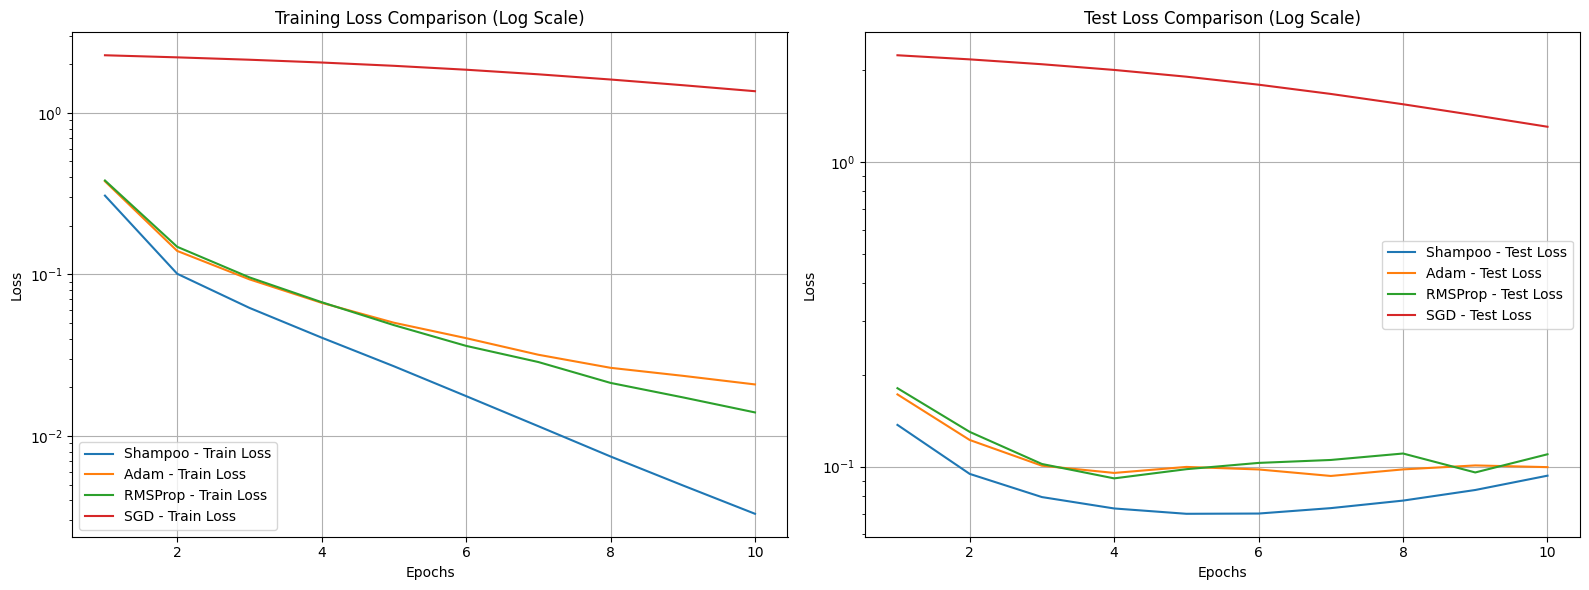

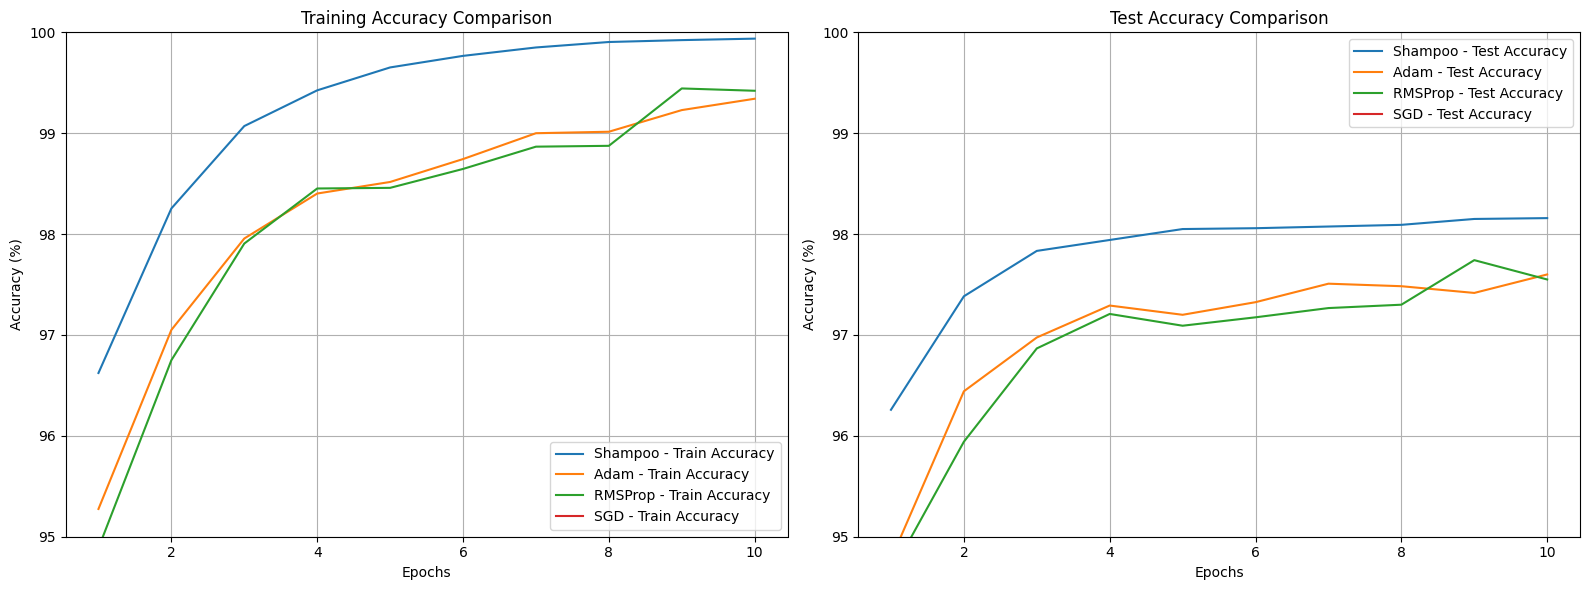

In [211]:
import matplotlib.pyplot as plt

# Create subplots for train and test loss side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train loss plot
axs[0].plot(epochs, metrics["train_loss"], label="Shampoo - Train Loss")
axs[0].plot(epochs, metrics_adam["train_loss"], label="Adam - Train Loss")
axs[0].plot(epochs, metrics_rmsprop["train_loss"], label="RMSProp - Train Loss")
axs[0].plot(epochs, metrics_sgd["train_loss"], label="SGD - Train Loss")
axs[0].set_title("Training Loss Comparison (Log Scale)")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_yscale("log")
axs[0].legend()
axs[0].grid()

# Test loss plot
axs[1].plot(epochs, metrics["val_loss"], label="Shampoo - Test Loss")
axs[1].plot(epochs, metrics_adam["val_loss"], label="Adam - Test Loss")
axs[1].plot(epochs, metrics_rmsprop["val_loss"], label="RMSProp - Test Loss")
axs[1].plot(epochs, metrics_sgd["val_loss"], label="SGD - Test Loss")
axs[1].set_title("Test Loss Comparison (Log Scale)")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_yscale("log")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# Create subplots for train and test accuracy side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train accuracy plot
axs[0].plot(epochs, metrics["train_accuracy"], label="Shampoo - Train Accuracy")
axs[0].plot(epochs, metrics_adam["train_accuracy"], label="Adam - Train Accuracy")
axs[0].plot(epochs, metrics_rmsprop["train_accuracy"], label="RMSProp - Train Accuracy")
axs[0].plot(epochs, metrics_sgd["train_accuracy"], label="SGD - Train Accuracy")
axs[0].set_title("Training Accuracy Comparison")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_ylim(95, 100)
axs[0].legend()
axs[0].grid()

# Test accuracy plot
axs[1].plot(epochs, metrics["val_accuracy"], label="Shampoo - Test Accuracy")
axs[1].plot(epochs, metrics_adam["val_accuracy"], label="Adam - Test Accuracy")
axs[1].plot(epochs, metrics_rmsprop["val_accuracy"], label="RMSProp - Test Accuracy")
axs[1].plot(epochs, metrics_sgd["val_accuracy"], label="SGD - Test Accuracy")
axs[1].set_title("Test Accuracy Comparison")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_ylim(95, 100)
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


In [214]:
class ShampooWithMomentum:
    def __init__(self, learning_rate=0.01, epsilon=1e-3, momentum=0.9):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.momentum = momentum
        self.L = None  # Left conditioners
        self.R = None  # Right conditioners
        self.momentum_state = None  # Momentum state

    def init_state(self, params):
        """
        Initialize the state (preconditioners and momentum) for all parameters.
        """
        def initialize_L(p):
            if p.ndim == 2:  # Weight matrices
                return jnp.eye(p.shape[0])  # Left preconditioner
            elif p.ndim == 1:  # Bias vectors
                return jnp.eye(p.shape[0])  # Treat as square matrix for bias
            return None

        def initialize_R(p):
            if p.ndim == 2:  # Weight matrices
                return jnp.eye(p.shape[1])  # Right preconditioner
            elif p.ndim == 1:  # Bias vectors
                return jnp.array(1.0)  # Scalar for bias
            return None

        def initialize_momentum(p):
            return jnp.zeros_like(p)

        self.L = jax.tree_util.tree_map(initialize_L, params)
        self.R = jax.tree_util.tree_map(initialize_R, params)
        self.momentum_state = jax.tree_util.tree_map(initialize_momentum, params)

    def _update_preconditioners(self, grads):
        """
        Update the left and right preconditioners using the gradients.
        """
        def update_L(L, grad):
            if grad is not None:
                if grad.ndim == 2:  # For 2D weight matrices
                    return L + grad @ grad.T
                elif grad.ndim == 1:  # For 1D bias vectors
                    return L + jnp.outer(grad, grad)  # Outer product
            return L

        def update_R(R, grad):
            if grad is not None:
                if grad.ndim == 2:  # For 2D weight matrices
                    return R + grad.T @ grad
                elif grad.ndim == 1:  # For 1D bias vectors
                    return R + grad @ grad  # Scalar (dot product)
            return R

        self.L = jax.tree_util.tree_map(lambda L, g: update_L(L, g), self.L, grads)
        self.R = jax.tree_util.tree_map(lambda R, g: update_R(R, g), self.R, grads)

    def _precondition_grads(self, grads):
        """
        Apply Shampoo preconditioning to the gradients.
        """
        def inverse_fourth_root_newton_schulz(A, num_iters=10, epsilon=1e-6, tol=1e-5, check_convergence=True):
            I = jnp.eye(A.shape[0])
            A_norm = A / (jnp.trace(A) + epsilon)  # Normalize A for stability
            X = I  # Initial guess
            M = A_norm

            for i in range(num_iters):
                # Compute the update for the inverse square root
                X = 0.5 * X @ (3 * I - M @ X)
                M = 0.5 * M @ (3 * I - M @ X)

                # Convergence check (optional)
                if check_convergence:
                    residual = jnp.linalg.norm(I - M @ X)
                    if residual < tol:
                        break

            # Compute the inverse fourth root by applying the inverse square root twice
            X_inv_fourth = X @ X

            # Scale back to the original matrix
            return X_inv_fourth / jnp.sqrt(jnp.trace(A) + epsilon)

        def precondition(L, R, grad):
            if grad.ndim == 2:  # For 2D weight matrices
                L_inv_sqrt = inverse_fourth_root_newton_schulz(L + self.epsilon * jnp.eye(L.shape[0]))
                R_inv_sqrt = inverse_fourth_root_newton_schulz(R + self.epsilon * jnp.eye(R.shape[0]))
                return L_inv_sqrt @ grad @ R_inv_sqrt
            elif grad.ndim == 1:  # For 1D bias vectors
                L_inv_sqrt = inverse_fourth_root_newton_schulz(L + self.epsilon * jnp.eye(L.shape[0]))
                R_inv_sqrt = 1 / (jnp.sqrt(R + self.epsilon))  # Scalar
                return L_inv_sqrt @ grad * R_inv_sqrt
            return grad  # Default: Return unmodified gradient if unsupported

        return jax.tree_util.tree_map(
            lambda L, R, g: precondition(L, R, g) if g is not None else g,
            self.L, self.R, grads
        )

    def update(self, params, grads):
        """
        Update the parameters using the preconditioned gradients and momentum.
        """
        if self.L is None or self.R is None or self.momentum_state is None:
            self.init_state(params)

        # Update preconditioners
        self._update_preconditioners(grads)

        # Normalize gradients
        grads = jax.tree_util.tree_map(lambda g: g / (jnp.linalg.norm(g) + self.epsilon) if g is not None else g, grads)

        # Precondition gradients
        preconditioned_grads = self._precondition_grads(grads)

        # Apply momentum
        def apply_momentum(momentum, grad):
            return self.momentum * momentum + grad

        self.momentum_state = jax.tree_util.tree_map(apply_momentum, self.momentum_state, preconditioned_grads)

        # Update parameters
        def apply_update(param, momentum):
            return param - self.learning_rate * momentum

        return jax.tree_util.tree_map(apply_update, params, self.momentum_state)


In [215]:
key = jax.random.PRNGKey(0)
net = MLP()
dummy_input = jnp.ones((1, 28 * 28))
params = net.init(key, dummy_input)["params"]

# Initialize Shampoo optimizer
shampoo_optimizer = ShampooWithMomentum(learning_rate=0.001, epsilon=1e-6)
shampoo_optimizer.init_state(params)  # Initialize with model parameters

# Training loop
epochs = 10
batch_size = 256

X_train = jax.device_put(X_train)  # Ensure training data is on GPU
y_train = jax.device_put(y_train)  # Ensure training labels are on GPU
X_val = jax.device_put(X_val)  # Validation data on GPU
y_val = jax.device_put(y_val)  # Validation labels on GPU
X_test = jax.device_put(X_test)  # Test data on GPU
y_test = jax.device_put(y_test)  # Test labels on GPU
params = jax.device_put(params)  # Model parameters on GPU

# Metrics storage
metrics_testing = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "epoch_time": []
}

for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    num_batches = len(X_train) // batch_size

    for i in range(num_batches):
        # Batch data
        batch = (X_train[i * batch_size: (i + 1) * batch_size],
                 y_train[i * batch_size: (i + 1) * batch_size])

        grads, loss = compute_grads(params, batch)
        params = shampoo_optimizer.update(params, grads)
        epoch_loss += loss

    # Compute metrics after epoch
    avg_train_loss = epoch_loss / num_batches
    train_logits = net.apply({"params": params}, X_train)
    val_logits = net.apply({"params": params}, X_val)
    train_accuracy = compute_accuracy(train_logits, y_train)
    val_accuracy = compute_accuracy(val_logits, y_val)
    val_loss = cross_entropy_loss(val_logits, y_val)

    # Log metrics
    metrics_testing["train_loss"].append(float(avg_train_loss))
    metrics_testing["val_loss"].append(float(val_loss))
    metrics_testing["train_accuracy"].append(float(train_accuracy) * 100)
    metrics_testing["val_accuracy"].append(float(val_accuracy) * 100)
    metrics_testing["epoch_time"].append(time.time() - start_time)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, "
      f"Epoch Time: {metrics_testing['epoch_time'][-1]:.2f}s")


# Final Test Accuracy
test_logits = net.apply({"params": params}, X_test)
test_accuracy = compute_accuracy(test_logits, y_test)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
Train Loss: 0.2942, Train Accuracy: 97.41%, Val Loss: 0.1285, Val Accuracy: 96.25%, Epoch Time: 227.82s
Epoch 2/10
Train Loss: 0.0994, Train Accuracy: 98.13%, Val Loss: 0.1265, Val Accuracy: 96.67%, Epoch Time: 225.01s
Epoch 3/10
Train Loss: 0.0673, Train Accuracy: 98.51%, Val Loss: 0.1248, Val Accuracy: 97.18%, Epoch Time: 223.81s
Epoch 4/10
Train Loss: 0.0511, Train Accuracy: 98.92%, Val Loss: 0.1340, Val Accuracy: 97.18%, Epoch Time: 224.53s
Epoch 5/10
Train Loss: 0.0407, Train Accuracy: 99.29%, Val Loss: 0.1427, Val Accuracy: 97.37%, Epoch Time: 224.25s
Epoch 6/10
Train Loss: 0.0338, Train Accuracy: 99.47%, Val Loss: 0.1440, Val Accuracy: 97.57%, Epoch Time: 222.66s
Epoch 7/10
Train Loss: 0.0277, Train Accuracy: 99.38%, Val Loss: 0.1662, Val Accuracy: 97.37%, Epoch Time: 223.07s
Epoch 8/10
Train Loss: 0.0248, Train Accuracy: 99.28%, Val Loss: 0.1954, Val Accuracy: 97.18%, Epoch Time: 221.74s
Epoch 9/10
Train Loss: 0.0250, Train Accuracy: 99.61%, Val Loss: 0.1656, Val Acc